Add all the imports and configure the python path

In [21]:

import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import types
import unittest
import io

# Add the services directory to the Python path
services_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if services_path not in sys.path:
    sys.path.append(services_path)

from services.agent_helpers import read_json_file
from services.result_evaluation import evaluate_codebleu_for_pairs, compute_and_print_codebleu_results, evaluate_time_logs
from services.output_validation import validate_python_syntax

In [22]:
# Specify and store all the file output and input directories.

OUTPUT_DIR = Path(os.getcwd()).parent / 'outputs'
GROUND_TRUTH = Path(os.getcwd()).parent / 'inputs' / 'ground_truth.json'
GROUND_TRUTH_TEST = Path(os.getcwd()).parent / 'inputs' / 'ground_truth_test.json'

SINGLE_AGENT_CODE_OUT = OUTPUT_DIR / 'single_agent_results'/ 'generated_python_code.json'
DOUBLE_AGENT_CODE_OUT = OUTPUT_DIR / 'double_agent_results'/ 'generated_python_code.json'
MULTI_AGENT_CODE_OUT = OUTPUT_DIR / 'multi_agent_results'/ 'generated_python_code.json'
SINGLE_AGENT_TIME_OUT = OUTPUT_DIR / 'single_agent_results'/ 'time_log.json'
DOUBLE_AGENT_TIME_OUT = OUTPUT_DIR / 'double_agent_results'/ 'time_log.json'
MULTI_AGENT_TIME_OUT = OUTPUT_DIR / 'multi_agent_results'/ 'time_log.json'

MULTI_AGENT_STATUS_OUT = OUTPUT_DIR / 'multi_agent_results'/ 'process_status.json'

Define method to plot the computed CodeBleu score

In [23]:
def plot_codebleu_results(avg_score_single_agent, avg_score_double_agent, avg_score_multi_agent):
    """
    Plots the CodeBLEU results for single and double agent evaluations.
    Enhanced with value labels, grid, and style.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    labels = ['Single Agent', 'Double Agent', 'Multi Agent']
    scores = [avg_score_single_agent, avg_score_double_agent, avg_score_multi_agent]
    colors = ['#4F81BD', '#F28E2B', '#A5D86D']
    hatches = ['/', '\\', '|']

    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(labels, scores, color=colors, edgecolor='black', hatch=hatches, width=0.5)

    ax.set_ylabel('Average CodeBLEU Score', fontsize=12)
    ax.set_title('CodeBLEU Evaluation Results', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.figtext(0.99, 0.01, 'Source: Multi-agent LLMs SE Research Thesis', 
                horizontalalignment='right', fontsize=8, color='gray')
    plt.show()


Define a method to plot the time taken for translation task

In [24]:
def plot_time_log_results(avg_single_agent_time, avg_double_agent_time, avg_multi_agent_time):
    """
    Plots the time log results for single, double, and multi agent evaluations.
    Enhanced with value labels, grid, and style.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    labels = ['Single Agent', 'Double Agent', 'Multi Agent']
    scores = [avg_single_agent_time, avg_double_agent_time, avg_multi_agent_time]
    colors = ['#4F81BD', '#F28E2B', '#A5D86D']
    hatches = ['/', '\\', '|']

    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(labels, scores, color=colors, edgecolor='black', hatch=hatches, width=0.5)

    ax.set_ylabel('Average Time (seconds)', fontsize=12)
    ax.set_title('Average time taken for the translation task', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(scores) * 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.figtext(0.99, 0.01, 'Source: Multi-agent LLMs SE Research Thesis',
                horizontalalignment='right', fontsize=8, color='gray')
    plt.show()

Define a method to compute the ratio of the codes that are compilable (CSR Score)

In [25]:
def compute_compile_ratio(output_codes):
    """
    Computes the compilation ratio for the translated code.
    """
    success_count = 0
    count = 0

    for key, translated_code in output_codes.items():
        result = validate_python_syntax(translated_code)
        if result.get("valid", True):
            success_count += 1
        count += 1

    return success_count / count if count > 0 else 0

Define a method to plot the compilation succes rate results

In [26]:
def plot_compile_ratio_results(avg_single_agent_ratio, avg_double_agent_ratio, avg_multi_agent_ratio):
    """
    Plots the compilation ratio results for single, double, and multi agent evaluations.
    Enhanced with value labels, grid, and style.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    labels = ['Single Agent', 'Double Agent', 'Multi Agent']
    scores = [avg_single_agent_ratio, avg_double_agent_ratio, avg_multi_agent_ratio]
    colors = ['#4F81BD', '#F28E2B', '#A5D86D']
    hatches = ['/', '\\', '|']

    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(labels, scores, color=colors, edgecolor='black', hatch=hatches, width=0.5)

    ax.set_ylabel('Average Compilation Ratio', fontsize=12)
    ax.set_title('Compilation Ratio Evaluation Results', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.figtext(0.99, 0.01, 'Source: Multi-agent LLMs SE Research Thesis',
                horizontalalignment='right', fontsize=8, color='gray')
    plt.show()

In [27]:
def run_one_target(name: str, code_str: str, tests_str: str):
    """
    Run translated code + test code together, return CA score.
    """
    mod = types.ModuleType(f"sut_{name}")
    g = mod.__dict__
    g["__name__"] = f"sut_{name}"   # so unittest.main() inside code won't trigger

    # Execute code then tests in same namespace
    exec(code_str, g, g)
    exec(tests_str, g, g)

    suite = unittest.defaultTestLoader.loadTestsFromModule(mod)
    stream = io.StringIO()
    result = unittest.TextTestRunner(stream=stream, verbosity=0).run(suite)

    total   = result.testsRun
    fails   = len(result.failures)
    errors  = len(result.errors)
    skipped = len(result.skipped)
    passed  = total - fails - errors - skipped
    ca      = (passed / total) if total else 0.0

    return {
        "tests_run": total,
        "passed": passed,
        "failures": fails,
        "errors": errors,
        "skipped": skipped,
        "ca_score": ca,
        "log": stream.getvalue(),
    }

In [28]:
def evaluate_CA(translated_codes: dict, ground_truth_tests: dict):
    """
    Run EVERY translated code against EVERY test set.
    Return overall average CA (across all runs).
    """
    results = {}
    ca_scores = []
    code_str = translated_codes.get("BalancedBrackets", "")
    tests_str = ground_truth_tests.get("BalancedBrackets", "")
    run_name = f"BalancedBrackets"
    print(f"Running {run_name}...")
    r = run_one_target(run_name, code_str, tests_str)
    ca_scores.append(r["ca_score"])
    # for code_key, code_str in list(translated_codes.items()):
    #     tests_str = ground_truth_tests.get(code_key, "")
    #     run_name = f"{code_key}"
    #     print(f"Running {run_name}...")
    #     r = run_one_target(run_name, code_str, tests_str)
    #     results[run_name] = r
    #     ca_scores.append(r["ca_score"])
    print(f"Finished running {run_name}. CA score: {r['ca_score']}")
    avg_ca = sum(ca_scores) / len(ca_scores) if ca_scores else 0.0
    return {"average_ca": avg_ca, "by_pair": results}

In [29]:
# Fetch the ground truth and the translated code output files
ground_truth = read_json_file(str(GROUND_TRUTH))
ground_truth_test = read_json_file(str(GROUND_TRUTH_TEST))
single_agent_code = read_json_file(str(SINGLE_AGENT_CODE_OUT))
double_agent_code = read_json_file(str(DOUBLE_AGENT_CODE_OUT))
multi_agent_code = read_json_file(str(MULTI_AGENT_CODE_OUT))

    # Compute time taken
single_agent_time = read_json_file(str(SINGLE_AGENT_TIME_OUT))
double_agent_time = read_json_file(str(DOUBLE_AGENT_TIME_OUT))
multi_agent_time = read_json_file(str(MULTI_AGENT_TIME_OUT))

    # Status file for multi_agent output
multi_agent_output_status = read_json_file(str(MULTI_AGENT_STATUS_OUT))

In [30]:
successful_keys = [
    key for key, value in list(multi_agent_output_status.items())
    if str(value).lower() == "success"
]

successful_outputs = {key: multi_agent_code[key] for key in successful_keys}
successful_output_times = {key: multi_agent_time[key] for key in successful_keys}

In [40]:
len(successful_keys)

66

Compute and Print CodeBleu Scores

In [32]:
    # Evaluate CodeBLEU scores
single_results = evaluate_codebleu_for_pairs(ground_truth, single_agent_code)
double_results = evaluate_codebleu_for_pairs(ground_truth, double_agent_code)
multi_results = evaluate_codebleu_for_pairs(ground_truth, successful_outputs)

avg_score_single_agent = compute_and_print_codebleu_results(single_results)
avg_score_double_agent = compute_and_print_codebleu_results(double_results)
avg_score_multi_agent = compute_and_print_codebleu_results(multi_results)

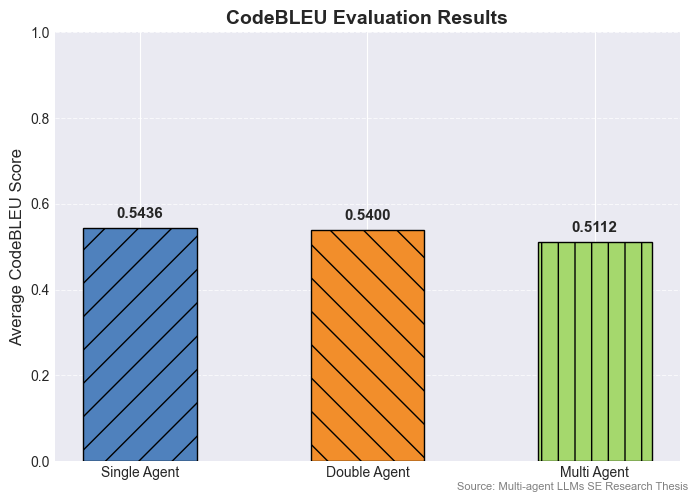

In [33]:
plot_codebleu_results(avg_score_single_agent, avg_score_double_agent, avg_score_multi_agent)

Compute and print translation task time metric

In [34]:
avg_single_agent_time = evaluate_time_logs(single_agent_time)
avg_double_agent_time = evaluate_time_logs(double_agent_time)
avg_multi_agent_time = evaluate_time_logs(successful_output_times)

AccessGatewayFilter: Time = 8.05361649999395
AreaCalculator: Time = 3.9686908000148833
ArgumentParser: Time = 8.61309280002024
ArrangementCalculator: Time = 7.571377100015525
AssessmentSystem: Time = 7.802765999978874
AutomaticGuitarSimulator: Time = 3.848669700033497
AvgPartition: Time = 2.4436550000100397
BalancedBrackets: Time = 4.0194388999952935
BankAccount: Time = 2.762500500015449
BigNumCalculator: Time = 12.802128899958916
BinaryDataProcessor: Time = 4.859619399998337
BitStatusUtil: Time = 3.2877047000220045
BlackjackGame: Time = 7.645672699960414
BookManagement: Time = 3.0925778000382707
BookManagementDB: Time = 9.066758800006937
BoyerMooreSearch: Time = 5.314400300034322
Calculator: Time = 8.608269800024573
CalendarUtil: Time = 9.250608800037298
CamelCaseMap: Time = 5.073425600014161
ChandrasekharSieve: Time = 3.3771611000411212
Chat: Time = 5.325412600010168
ClassRegistrationSystem: Time = 7.570210499980021
Classroom: Time = 9.645616900001187
CombinationCalculator: Time = 4.

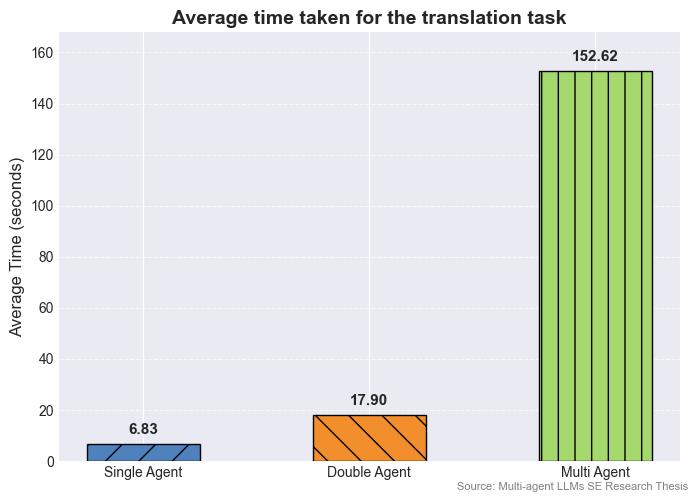

In [35]:
plot_time_log_results(avg_single_agent_time, avg_double_agent_time, avg_multi_agent_time)

Compute CSR Score and plot the results

In [36]:
    # Compute compilation ratios
single_agent_compile_ratio = compute_compile_ratio(single_agent_code)
double_agent_compile_ratio = compute_compile_ratio(double_agent_code)
multi_agent_compile_ratio = compute_compile_ratio(successful_outputs)

    # Plot results



 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1708 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 930 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1980 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1652 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1811 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 859 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 490 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 878 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 669 characters
 Python syntax is vali

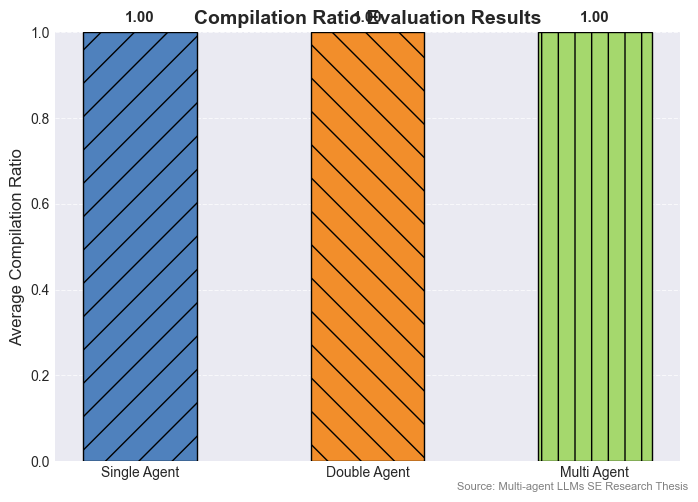

In [37]:
plot_compile_ratio_results(single_agent_compile_ratio, double_agent_compile_ratio, multi_agent_compile_ratio)

Print average number of passed/ failed test cases for successful and errored translation.

In [38]:
MULTI_AGENT_TESTER_OUT_DIR = OUTPUT_DIR / 'multi_agent_results' / 'generated_tests.json'

tester_outputs = read_json_file(str(MULTI_AGENT_TESTER_OUT_DIR))  # fetch all outputs of the tester agent for all programs.

# Ensure tester_outputs is a dict
if not isinstance(tester_outputs, dict):
    print(f"Warning: tester_outputs is not a dict (type={type(tester_outputs)}). Treating as empty dict.")
    tester_outputs = {}

# Filter to select only those outputs from successful program runs,
# but only include keys that actually exist in tester_outputs
successful_tester_outputs = {}
missing_keys = []
for key in successful_keys:
    if key in tester_outputs:
        successful_tester_outputs[key] = tester_outputs[key]
    else:
        missing_keys.append(key)

if missing_keys:
    print(f"key not found in tester_outputs: {len(missing_keys)} {missing_keys[:10]}{'...' if len(missing_keys)>10 else ''}")

import re
# Regex to capture the content of the fenced ```test_results block
pattern = r"```test_results(?:\r?\n)([\s\S]*?)```"

last_test_results = {}

for key, output in successful_tester_outputs.items():
    matches = re.findall(pattern, str(output))
    if matches:
        last_test_results[key] = matches[-1].strip()  # take last occurrence and trim whitespace

# Now last_test_results contains the mapping
print(last_test_results)


key not found in tester_outputs: 2 ['Hotel', 'JobMarketplace']
{'AccessGatewayFilter': 'Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 7\n-PASS/FAIL COUNT FOR EACH CODE:\n C++: 7 passed, 0 failed\n Python: 7 passed, 0 failed\n-ANY DIFFERENCES IN TEST OUTCOMES BETWEEN THE TWO IMPLEMENTATIONS:\n No differences; all test outcomes matched.', 'AreaCalculator': 'Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 0\n-C++: 0 passed, 0 failed\n-Python: 0 passed, 0 failed\n-ANY DIFFERENCES IN TEST OUTCOMES BETWEEN THE TWO IMPLEMENTATIONS: None reported (tool returned match=True)\n\nNote: The external execute_and_compare_tests tool returned no executed tests (total=0). The test definitions for both C++ and Python were provided above and are consistent (unique test names match across both). If you want, I can re-run with adjustments or attempt to diagnose why tests did not execute in the environment.', 'ArrangementCalculator': "Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 9\n-C++: 0 passed, 9 fai

In [39]:
import re
from statistics import mean

# patterns (case-insensitive)
total_patterns = [
    re.compile(r"TOTAL NUMBER OF TESTS EXECUTED:\s*([0-9]+)", re.I),
    re.compile(r"([0-9]+)\s*tests\s*executed", re.I),        # regex to fetch number of tests executed.
    re.compile(r"Test Summary:\s*-\s*([0-9]+)\s*tests\s*executed", re.I),
]
py_pass_pat = re.compile(r"Python:\s*([0-9]+)\s*passed", re.I) #regex to fetch the number of python tests passed.

per_key = {}
totals = []
passed = []
ratios = []

for key, text in last_test_results.items():
    s = str(text)
    # find total tests
    total = None
    for p in total_patterns:
        m = p.search(s)
        if m:
            total = int(m.group(1))
            break

    # find python passed count
    m_py = py_pass_pat.search(s)
    py_passed = int(m_py.group(1)) if m_py else None

    ratio = None
    if total is not None and py_passed is not None:
        ratio = py_passed / total if total > 0 else 0.0
        totals.append(total)
        passed.append(py_passed)
        ratios.append(ratio)

    per_key[key] = {"total_tests": total, "python_passed": py_passed, "passed_ratio": ratio}

avg_total_tests = mean(totals) if totals else 0.0
avg_passed_tests = mean(passed) if passed else 0.0
avg_pass_ratio = mean(ratios) if ratios else 0.0

print("per_key summary (sample):", {k: per_key[k] for k in list(per_key)})
print("avg_total_tests:", avg_total_tests)
print("avg_passed_tests:", avg_passed_tests)
print("avg_pass_ratio:", avg_pass_ratio)


per_key summary (sample): {'AccessGatewayFilter': {'total_tests': 7, 'python_passed': 7, 'passed_ratio': 1.0}, 'AreaCalculator': {'total_tests': 0, 'python_passed': 0, 'passed_ratio': 0.0}, 'ArrangementCalculator': {'total_tests': 9, 'python_passed': 9, 'passed_ratio': 1.0}, 'AssessmentSystem': {'total_tests': 10, 'python_passed': None, 'passed_ratio': None}, 'AutomaticGuitarSimulator': {'total_tests': 10, 'python_passed': None, 'passed_ratio': None}, 'AvgPartition': {'total_tests': None, 'python_passed': 10, 'passed_ratio': None}, 'BankAccount': {'total_tests': 10, 'python_passed': 10, 'passed_ratio': 1.0}, 'BinaryDataProcessor': {'total_tests': 8, 'python_passed': 8, 'passed_ratio': 1.0}, 'BitStatusUtil': {'total_tests': None, 'python_passed': 10, 'passed_ratio': None}, 'BlackjackGame': {'total_tests': 9, 'python_passed': 9, 'passed_ratio': 1.0}, 'BookManagement': {'total_tests': 10, 'python_passed': 10, 'passed_ratio': 1.0}, 'BookManagementDB': {'total_tests': 8, 'python_passed': 8,